# Exercise 8: Dive into Few-Shot Learning 🚀

In this exercise, you'll:

1. Learn about the few-shot-learning concept and ways to tackle it.
2. Get a walkthrough of the `Few-Shot-Bench` code base. This code base offers a structured way to compare various methods meta-learning methods an various datasets. Depending on the project you choose, this might be helpful.

Let's get started and explore this together.

------------------
# 0.0 Environment Setup

In [1]:
!pip install -r requirements.txt

In [2]:
from abc import abstractmethod, ABC
import os

import torch.nn as nn
import numpy as np
import torch
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

from IPython.display import clear_output
from fcnet import FCNet
import display_utils
import gdown

import matplotlib.pyplot as plt

In [3]:
url = 'https://drive.google.com/u/0/uc?id=1a3IFmUMUXBH8trx_VWKZEGteRiotOkZS&export=download'

if os.path.exists('swissprot.zip'):
    print('File already downloaded.')
else:
    output = 'swissprot.zip'
    gdown.download(url, output, quiet=False)
    print('Download completed.')

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1a3IFmUMUXBH8trx_VWKZEGteRiotOkZS&export=download
From (redirected): https://drive.google.com/uc?id=1a3IFmUMUXBH8trx_VWKZEGteRiotOkZS&export=download&confirm=t&uuid=4bd3754d-94cc-4b4c-9293-1ceb292a737e
To: /Users/ludekcizinsky/Dev/personal/epfl-cs502/coursework/exercises/w8/swissprot.zip
100%|██████████| 180M/180M [00:13<00:00, 13.5MB/s] 

Download completed.


In [4]:
!unzip -q swissprot.zip

!rm -rf swissprot.zip
clear_output()

!mv data/swissprot/go-basic.obo ./

In [5]:
from utils import get_samples_using_ic, check_min_samples, get_mode_ids, encodings, get_ids

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2023-06-11) 46,420 Terms; optional_attrs(relationship)


------------------

# 1.0 [Protonet](https://arxiv.org/abs/1703.05175)

Imagine trying to recognize and classify new objects after seeing them just once or a few times. It's a tough task for most machine learning models. This is called few-shot classification. Humans can often identify objects even after seeing them just once. So, how can we make machines do that too?

Prototype networks work on a basic idea: objects of the same type should be similar to each other in some way. So, in a space where the data is mapped tp, objects from the same class are expected to cluster around a central point, or a 'prototype'. When a new object comes in, the network checks which prototype it's closest to and classifies it accordingly.

This method not only works for cases where we have a few examples but also for zero-shot learning, where we have no prior examples at all! Instead, we use a high-level description to determine the prototype.

In short, prototype networks help in classifying new objects by looking for similarities to known prototypes, making them both efficient and effective for tasks with limited data.

## 1.1 Creating a Meta-Template for Few-Shot Tasks
In this exercise, we'll focus on implementing the Protonet using the `Few-Shot-Bench` code base. This code base offers a structured way to compare various methods. It has a template designed to add new methods and assess their performance seamlessly.

The template has a standard training and testing cycle for meta-learning techniques. To train and test our model, we have two primary tasks:

Mapping our data to the embeddings space: This step is facilitated by the parse_features function. Through this function, we'll calculate the prototypes (or support) and queries (or embeddings) for each data point.

Evaluating our model's performance: The correct function will help us with this. It measures how accurately our model classifies data.

Your task is to complete the implementation of the `parse_features` and `correct` functions

In [6]:
class MetaTemplate(nn.Module):
    def __init__(self, backbone, n_way, n_support):
        super(MetaTemplate, self).__init__()
        self.n_way = n_way
        self.n_support = n_support
        self.n_query = -1  # (change depends on input)
        self.feature = backbone
        self.feat_dim = self.feature.final_feat_dim

        if torch.cuda.is_available():
            self.device = torch.device("cuda")
        else:
            self.device = torch.device("cpu")

    @abstractmethod
    def set_forward(self, x, is_feature=False):
        """
        :param x: [n_way, n_support + n_query, **embedding_dim]
        :param is_feature: True if x is already embedding
        :return: [n_way * n_query, **embedding_dim]
        """
        pass

    @abstractmethod
    def set_forward_loss(self, x):
        """
        :param x: [n_way, n_support + n_query, **embedding_dim]
        :return: scalar values of loss
        """
        pass

    def forward(self, x):
        out = self.feature.forward(x)
        return out

    def parse_feature(self, x):
        '''
        :param x: [n_way, n_support + n_query, **embedding_dim]
        '''
        x = Variable(x.to(self.device))
        x = x.contiguous().view(self.n_way * (self.n_support + self.n_query), * x.size()[2:])
        # Compute support and query feature.
        z_all = self.forward(x)

        # Reverse the transformation to distribute the samples based on the dimensions of their individual categories and flatten the embeddings.
        z_all = z_all.view(self.n_way, self.n_support + self.n_query, -1) # View operation never creeates memory copy of tensor

        # Extract the support and query features.
        z_support = z_all[:, :self.n_support]
        z_query = z_all[:, self.n_support:]

        return z_support, z_query

    def correct(self, x):
        # Compute the predictions scores.
        scores = self.set_forward(x)

        # Compute the top1 elements.
        # How many k's do we want to consider? --> for each column we want to consider the top 1 element.
        topk_scores, topk_labels = scores.data.topk(1, 1, True, True) 

        # Detach the variables.
        topk_ind = topk_labels.cpu().numpy().astype(np.int32)

        # Create the category labels for the queries.
        y_query = np.repeat(range(self.n_way), self.n_query)

        # Compute number of elements that are correctly classified.
        top1_correct = np.sum(topk_ind[:, 0] == y_query)
        return float(top1_correct), len(y_query)

    def train_loop(self, epoch, train_loader, optimizer):
        print_freq = 10

        avg_loss = 0
        for i, (x, _) in enumerate(train_loader):
            self.n_query = x.size(1) - self.n_support
            optimizer.zero_grad()
            loss = self.set_forward_loss(x)
            loss.backward()
            optimizer.step()
            avg_loss = avg_loss + loss.item()

            if i % print_freq == 0:
                print('Epoch {:d} | Batch {:d}/{:d} | Loss {:f}'.format(epoch, i, len(train_loader),
                                                                        avg_loss / float(i + 1)))
        return avg_loss/len(train_loader)
    
    def test_loop(self, epoch, test_loader, record=None, return_std=False):
        acc_all = []

        iter_num = len(test_loader)
        for i, (x, _) in enumerate(test_loader):
            self.n_query = x.size(1) - self.n_support
            correct_this, count_this = self.correct(x)
            acc_all.append(correct_this / count_this * 100)

        acc_all = np.asarray(acc_all)
        acc_mean = np.mean(acc_all)
        acc_std = np.std(acc_all)
        print(f'Epoch {epoch} | Test Acc = {acc_mean:4.2f}% +- {1.96 * acc_std / np.sqrt(iter_num):4.2f}%')

        if return_std:
            return acc_mean, acc_std
        else:
            return acc_mean

## 1.2 ProtoNet Implementation
Now we are ready to extend the MetaTemplate with the ProtoNet specific implementation.

Your task is to write the code for two functions: `set_forward` and `set_forward_loss`.

1. `set_forward`: This function should calculate the prototypes (referred to as `support`) and queries (referred to as `embeddings`) for every data point. After that, determine the **similarity** between these prototypes and queries.
2. `set_forward_loss`: With this function, your goal is to calculate the model's loss.

In [7]:
class ProtoNet(MetaTemplate):
    def __init__(self, backbone, n_way, n_support):
        super(ProtoNet, self).__init__(backbone, n_way, n_support)
        self.loss_fn = nn.CrossEntropyLoss()

    def set_forward(self, x):
        # Compute the prototypes (support) and queries (embeddings) for each datapoint.
        # Remember that you implemented a function to compute this before.
        z_support, z_query = self.parse_feature(x)
            
        # Compute the prototype.
        z_support = z_support.contiguous().view(self.n_way, self.n_support, -1)
        z_proto = z_support.mean(1)
        
        # Format the queries for the similarity computation.
        z_query = z_query.contiguous().view(self.n_way * self.n_query, -1)

        # Compute similarity score based on the euclidean distance between prototypes and queries.
        scores = -euclidean_dist(z_query, z_proto)
        return scores

    def set_forward_loss(self, x):
        # Compute the similarity scores between the prototypes and the queries.
        scores = self.set_forward(x)
        
        # Create the category labels for the queries.
        y_query = torch.from_numpy(np.repeat(range(self.n_way), self.n_query))
        y_query = Variable(y_query.to(self.device))

        # Compute the loss
        loss = self.loss_fn(scores, y_query.to(self.device))
        return loss

def euclidean_dist( x, y):
    # x: N x D
    # y: M x D
    n = x.size(0)
    m = y.size(0)
    d = x.size(1)
    assert d == y.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    return torch.pow(x - y, 2).sum(2)

------------------
# 2.0 Dataset - [SwissProt](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC102476/)

Now, let's dive into the world of proteins to test the power of the ProtoNet! 🧬

Proteins are like intricate puzzles made up of smaller pieces known as amino acids. These tiny building blocks come together in a specific order to give a protein its unique structure and function in living organisms. It's like assembling LEGO blocks in a specific order to build a spaceship or a castle!

Now, imagine we had a vast library of labels to describe each protein's function. Welcome to SwissProt dataset, which is annotated with Gene Ontology (GO) labels! The Gene Ontology Consortium (GOC), an international team of experts, crafted these labels to categorize the role, location, and function of genes across various species.

The ontology includes over 47,000 terms (as of April 2018), each representing a specific characteristic or label. Think of these labels as descriptors that can be linked together. For instance, a protein might be described by its role in cell division, its location in the cell's nucleus, and its ability to bind to DNA. This results in a directed acyclic graph (DAG) structure of GO labels, where the nodes are the labels and the edges are the relationships between them. When a protein is linked to a specific label, it's also connected to all the labels that are ancestors in the DAG. This makes our machine learning challenge one of multi-label classification, meaning each protein can have multiple labels.

For our exercise on fewshot learning, which mainly focuses on single-label classification, we need a method to assign just one label to each protein. We achieve this by choosing the most detailed label from the GO DAG for every protein. We've provided a procedure (get_samples_using_ic) that does this for you and also loads the dataset in the format you'll need.

## 2.1 Creating a Dataset Template for the Few-Shot Task
Let's keep our focus on our second objective: acquainting you with the `Few-Shot-Bench` code base. This library not only allows to measure the performance of various methods but also facilitates comparisons across multiple datasets. For this exercise, we'll start by examining the `FewShotDataset` template and SwissProt (SP) specialized version, the `SPDataset` before delving into the episodes data set for the SwissProt dataset, `SPSetDataset`, for the episodic training.

**Note**: We're not expecting you to write any code for this. Instead, we want you to familiarize yourself with the code structure and understand the dataset's layout.

In [8]:
class FewShotDataset(Dataset):

    def __init__(self):
        self.check_init()

    def check_init(self):
        """
        Convenience function to check that the FewShotDataset is properly configured.
        """
        required_attrs = ['_dataset_name', '_data_dir']
        for attr in required_attrs:
            if not hasattr(self, attr):
                raise ValueError(f'FewShotDataset must have attribute {attr}.')

        if not os.path.exists(self._data_dir):
            raise ValueError(
                f'{self._data_dir} does not exist yet. Please generate/download the dataset first.')


    @abstractmethod
    def __getitem__(self, i):
        return NotImplemented

    @abstractmethod
    def __len__(self):
        return NotImplemented

    @property
    @abstractmethod
    def dim(self):
        return NotImplemented

    @abstractmethod
    def get_data_loader(self, mode='train') -> DataLoader:
        return NotImplemented

    @property
    def dataset_name(self):
        """
        A string that identifies the dataset, e.g., 'swissprot'
        """
        return self._dataset_name

    @property
    def data_dir(self):
        return self._data_dir

    def initialize_data_dir(self, root_dir):
        os.makedirs(root_dir, exist_ok=True)
        self._data_dir = os.path.join(root_dir, self._dataset_name)

class SPDataset(FewShotDataset, ABC):
    _dataset_name = 'swissprot'

    def load_swissprot(self, level = 5, mode='train', min_samples = 20):
        samples = get_samples_using_ic(root = self.data_dir)
        samples = check_min_samples(samples, min_samples)
        unique_ids = set(get_mode_ids(samples)[mode])
        return [sample for sample in samples if sample.annot in unique_ids]

## 2.2 Creating an Episode Dataset for the SwissProt Dataset


In this exercise, you'll be working on creating an episode dataloader for the SwissProt dataset, which we need for training the ProtoNet model. Think of an episode dataset as a series of episodes, where each episode is made up of specific classes and their associated samples.

Here's a breakdown:

**Episode**: A group of n classes (n_way).

**Each Class in an Episode**: Contains `k` support samples (`n_support`) used for training and `q` query (`n_query`) samples used for evaluating performance.

Your task is to complete the episode dataloader `SPSetDataset` by creating a dataloaders for each category and implement the iterator function for the `EpisodicBatchSampler`.

In [9]:
PROTDIM = 1280

class SubDataset(Dataset):
    def __init__(self, samples, data_dir):
        self.samples = samples
        self.encoder = encodings(data_dir)

    def __getitem__(self, i):
        sample = self.samples[i]
        return sample.input_seq, self.encoder[sample.annot]

    def __len__(self):
        return len(self.samples)

    @property
    def dim(self):
        return PROTDIM

class EpisodicBatchSampler(object):
    def __init__(self, n_classes, n_way, n_episodes):
        self.n_classes = n_classes
        self.n_way = n_way
        self.n_episodes = n_episodes

    def __len__(self):
        return self.n_episodes

    def __iter__(self):
        for i in range(self.n_episodes):
            # Random sample the `n_way` classes for this episode.
            # This is needed to return the indices for the selected category dataloaders for this episode.
            yield np.random.choice(range(self.n_classes), self.n_way, False)

class SPSetDataset(SPDataset):
    def __init__(self, n_way, n_support, n_query, n_episode=100, root='./data', mode='train'):
        self.initialize_data_dir(root)

        self.n_way = n_way
        self.n_episode = n_episode
        min_samples = n_support + n_query
        self.encoder = encodings(self.data_dir)

        samples_all = self.load_swissprot(mode = mode, min_samples = min_samples)

        self.categories = get_ids(samples_all) # Unique annotations
        self.x_dim = PROTDIM

        self.sub_dataloader = []

        sub_data_loader_params = dict(batch_size=min_samples,
                                      shuffle=True,
                                      num_workers=0,  # use main thread only or may receive multiple batches
                                      pin_memory=False)

        # Create the sub datasets for each annotation of the categories and collect all the dataloaders in `self.sub_dataloader`.
        self.sub_dataloader = []
        for category in self.categories:
            samples = [sample for sample in samples_all if sample.annot == category]
            sub_dataset = SubDataset(samples, self.data_dir)
            self.sub_dataloader.append(torch.utils.data.DataLoader(sub_dataset, **sub_data_loader_params))

        super().__init__()

    def __getitem__(self, i):
        # Return the next batch of the dataloader of the i-th category.
        return next(iter(self.sub_dataloader[i]))

    def __len__(self):
        return len(self.categories)

    @property
    def dim(self):
        return self.x_dim

    def get_data_loader(self) -> DataLoader:
        sampler = EpisodicBatchSampler(len(self), self.n_way, self.n_episode)
        data_loader_params = dict(batch_sampler=sampler, num_workers=0, pin_memory=True)
        data_loader = torch.utils.data.DataLoader(self, **data_loader_params)
        return data_loader

------------------

# 3.0 Training and testing the model 
Now, we are going to train our Protonet model and see how it performs on the SwissProt dataset.

**A heads up:** Loading the training dataset might take around 2 minutes and loading the test set about 40 seconds.

In [13]:
def train_model(n_way, n_support, n_query, n_train_episode):
    # Load train dataset. Remember to use make use of functions defined in the `SPSetDataset`.
    train_dataset = SPSetDataset(n_way, n_support, n_query, n_episode=n_train_episode, root='./data', mode='train')
    train_loader = train_dataset.get_data_loader()

    # Load test dataset. Remember to use make use of functions defined in the `SPSetDataset`.
    test_dataset = SPSetDataset(n_way, n_support, n_query, n_episode=100, root='./data', mode='test')
    test_loader = test_dataset.get_data_loader()

    # Initialize a fully connected network `FCNet` in `fcnet.py` with two hidden layers of 512 units each as feature extractor.
    backbone = FCNet(train_dataset.dim, layer_dim=[512, 512])

    # Initialize model using the backbone and the optimizer.
    model = ProtoNet(backbone, n_way, n_support)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    test_accs = []; train_losses = []
    for epoch in range(100):

        # Implement training of the model. Remember to make use of functions defined in the `ProtoNet` and `MetaTemplate` class.
        model.train()
        epoch_loss = model.train_loop(epoch, train_loader, optimizer)
        train_losses.append(epoch_loss)

        # Evaluate test performance for epoch. Remember to make use of functions defined in the `ProtoNet` and `MetaTemplate` class.
        model.eval()
        test_acc = model.test_loop(epoch, test_loader)
        test_accs.append(test_acc)
        print(f'Epoch {epoch} | Train Loss {epoch_loss} | Test Acc {test_acc}')
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2.5))
    ax1.plot(range(len(train_losses)), train_losses)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Train Loss')
    ax1.grid()

    ax2.plot(range(len(test_accs)), test_accs)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Test Accuracy')
    ax2.grid()
    fig.suptitle(f"n_way={n_way}, n_support={n_support}, n_query={n_query}, n_train_episode={n_train_episode}")

    plt.tight_layout()

In [14]:
parameters = {'n_way': 5, 'n_support': 5, 'n_query': 15, 'n_train_episode': 5}
display_utils.sliders(parameters)


**WARNING: NO VERSION LINE FOUND IN GAF FILE. USING:
!gaf-version: 2.2


ERROR:root:Failed to validate header as GAF v2.2:
[]


HMS:0:00:05.769288 310,057 annotations READ: ./data/swissprot/filtered_goa_uniprot_all_noiea.gaf 
25933 IDs in loaded association branch, BP

**WARNING: NO VERSION LINE FOUND IN GAF FILE. USING:
!gaf-version: 2.2


ERROR:root:Failed to validate header as GAF v2.2:
[]


HMS:0:00:06.371681 310,057 annotations READ: ./data/swissprot/filtered_goa_uniprot_all_noiea.gaf 
25933 IDs in loaded association branch, BP
Epoch 0 | Batch 0/5 | Loss 6.293633
Epoch 0 | Test Acc = 61.05% +- 1.64%
Epoch 0 | Train Loss 14.512180042266845 | Test Acc 61.05333333333333
Epoch 1 | Batch 0/5 | Loss 17.120865
Epoch 1 | Test Acc = 61.56% +- 1.78%
Epoch 1 | Train Loss 13.06644172668457 | Test Acc 61.56
Epoch 2 | Batch 0/5 | Loss 9.306538
Epoch 2 | Test Acc = 60.53% +- 1.71%
Epoch 2 | Train Loss 6.74162209065658 | Test Acc 60.53333333333333
Epoch 3 | Batch 0/5 | Loss 12.615800
Epoch 3 | Test Acc = 62.65% +- 1.85%
Epoch 3 | Train Loss 14.271067428588868 | Test Acc 62.653333333333336
Epoch 4 | Batch 0/5 | Loss 21.991978
Epoch 4 | Test Acc = 63.56% +- 1.77%
Epoch 4 | Train Loss 13.753737258911134 | Test Acc 63.56
Epoch 5 | Batch 0/5 | Loss 34.724773
Epoch 5 | Test Acc = 65.71% +- 1.79%
Epoch 5 | Train Loss 14.270578289031983 | Test Acc 65.70666666666666
Epoch 6 | Batch 0/5 | Loss 9.

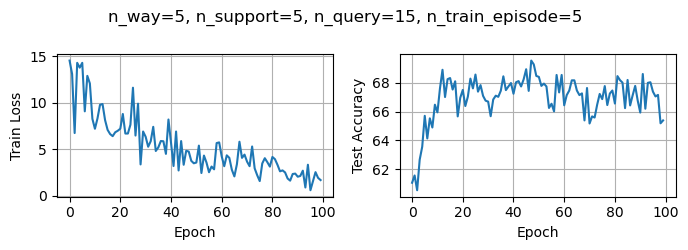

In [15]:
train_model(**parameters)